# 🎧 Last.fm Word Clouds in Python

This notebook provides some first steps in creating word clouds from your Last.fm listening history.

The following environment variables must be configured:
- LASTFM_API_KEY
- LASTFM_API_SECRET
- LASTFM_USERNAME (optionally, this will be the username for which the report is generated)

## ⚠️ Before running the notebook

**If you are running this on GitHub Codespaces**, you can [configure the encrypted GitHub Codespaces secrets](https://docs.github.com/en/codespaces/managing-your-codespaces/managing-encrypted-secrets-for-your-codespaces).

**If you are running this locally**, you can create a file called `.env` in the same directory as this notebook and add the following lines:

```bash
LASTFM_API_KEY=<your API key>
LASTFM_API_SECRET=<your API secret>
LASTFM_USERNAME=<your Last.fm username>
```

## Importing the libraries + setting up the environment

In [1]:
# Standard Python packages
##########################

import datetime
import os
import string
import sys

# Third-party packages (installed with pipenv and the Pipfile)
##############################################################

import calmap                    # generate calendar maps
import dotenv                    # load environment variables from a .env file
import matplotlib.pyplot as plt  # plotting
import pandas as pd              # table manipulation
import pylast                    # access the Last.fm API
import pywaffle                  # generate waffle charts
import wordcloud                 # generate word clouds (uses pandas, numpy, matplotlib)

# Constants
###########

EXTRA_PUNCTUATION = "«»“”‘’…–—"
MAX_TRACKS_TO_FETCH = 900

In [3]:
# Load environment variables from .env file (if one exists)
# This is useful when running this notebook locally, rather than through Codespaces

dotenv.load_dotenv()

# Ensure we have the required environment variables or ask for user input

if os.getenv("LASTFM_API_KEY") is None:
    print(
        "You may have forgotten to configure your encrypted GitHub Codespaces secret; "
        "or if you are working locally, you may have forgotten to set up the .env file. "
        "Please read Step 3 in README.md\n\n"
        "You may now get to enter them manually for this time (look for the prompt at the top of the window)."
    )

LASTFM_API_KEY = os.getenv("LASTFM_API_KEY") or input("Enter Last.fm API key: ")
LASTFM_API_SECRET = os.getenv("LASTFM_API_SECRET") or input("Enter Last.fm API secret: ")
LASTFM_USERNAME = os.getenv("LASTFM_USERNAME") or input("Enter Last.fm username: ")

You may have forgotten to configure your encrypted GitHub Codespaces secret; or if you are working locally, you may have forgotten to set up the .env file. Please read Step 3 in README.md


In [11]:
# Login to Last.fm API; in the rest of the notebook we will use the object
# `network` to access the API.

network = pylast.LastFMNetwork(
    api_key=LASTFM_API_KEY,
    api_secret=LASTFM_API_SECRET,

    # By not logging in with username + password, our access to Last.fm is READ-ONLY
    # (which is all we need for this notebook)
    username=None,
    password_hash=None,
)

The function below is actually more important than first appears. It is responsible for determining what text to associate to a track. Since the word cloud depends on the exact constitution of the text that is provided, this function, by controlling how a track is described in text, controls the word cloud.

Currently, this function:
- formats a track as `<Track name> <Artist name>`;
- removes punctuation and double spacing;
- removes words that are shorter than `smallest_word_allowed` characters (by default this is 0, so no words are removed).

It could be modified in any number of way. For example:
- you could add the album name to the track description;
- you could remove the artist name from the track description;
- you could remove the track name from the track description (and only use the artist name);
- you could use only the album and artist name.

These different parameters could be used to create different word clouds, each with a different focus; they could also be appropriate for different musical genres.

In [12]:
# This method takes a pylast.Track object and returns a string that contains all
# the textual information we want to be included in the word cloud, i.e., currently
# the track name and artist name.

def convert_track_name(
    track: pylast.Track,
    normalize: bool = True,
    smallest_word_allowed: int = 0,
) -> str:
    """
    Returns a string from a pylast.Track object that is suitable for use in a word cloud.
    """
    # Get the track name and artist name (e.g. "Hey Jude The Beatles")
    caption = f"{track.track.get_name()} {track.track.get_artist().get_name()}"

    # If normalize is False, return the string without cleaning it up
    if not normalize:
        return caption

    # Remove standard punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))

    # Remove extra punctuation
    for c in EXTRA_PUNCTUATION:
        caption = caption.replace(c, "")

    # Remove double spaces and leading/trailing spaces
    caption = caption.replace("  ", " ").strip()

    # Remove words smaller than three letters
    caption = " ".join([w for w in caption.split(" ") if len(w) > smallest_word_allowed])

    return caption

## Word Cloud Visualisation: Track and Artist Names

See the galleries of examples from the `wordcloud` package for more inspiration:
https://amueller.github.io/word_cloud/auto_examples/index.html

In [13]:
# Get the most recent tracks played by the user

tracks_raw_data = network.get_user(LASTFM_USERNAME).get_recent_tracks(limit=MAX_TRACKS_TO_FETCH)

# Convert the list of tracks into a list of strings, convert_track_name() is defined above
# and takes a pylast.Track object and returns a string that contains the track and artist names

tracks_name = [
    convert_track_name(track, normalize=True)
    for track in tracks_raw_data
]

# Create a big string that contains a line for each track
# (we use the str.join function to do so:
# https://docs.python.org/3/library/stdtypes.html#str.join)

tracks_text = "\n".join(tracks_name)

# Create a frequency dictionary that contains the number of times each word appears
# we split the whole text using the str.split function, which splits at white space:
# https://docs.python.org/3/library/stdtypes.html#str.split)

tracks_freqdict = {}
for word in tracks_text.split():
    if word not in tracks_freqdict:
        # If the word is not in the dictionary, we add it with frequency 1
        tracks_freqdict[word] = 1
    else:
        # If it is already in the dictionary, we increase the frequency
        tracks_freqdict[word] += 1

# Print the first few lines

print("TEXT:")
print(tracks_text[:1000])
print()

# Print the first few words and their frequencies

print("FREQUENCY DICT:")
print(sorted(tracks_freqdict.items(), key=lambda pair: pair[1], reverse=True)[:10])
print()

TEXT:
Sonata in FSharp Minor R 90 Allegro Antonio Soler
Sonata in D Minor R 120 Allegro spirituoso Antonio Soler
Sonata in A Major R 1 Allegro Antonio Soler
Sonata in FSharp Minor R 90 Allegro Antonio Soler
Sonata in Fsharp Major R 90 I Allegro Antonio Soler
Auf meinen lieben Gott BuxWV 179 I Allemande Double Dietrich Buxtehude
Balbastre Premier livre de pièces de clavecin XII La Suzanne Claude Balbastre
Lully Transc Tharaud Le bourgeois gentilhomme LWV 43 Marche pour la cérémonie des Turcs JeanBaptiste Lully
Duphly Troisième livre de pièces de clavecin VIII La de Belombre Jacques Duphly
Couperin F Second Livre de pièces de clavecin Huitième Ordre IX Passacaille François Couperin
DAnglebert Pièces de clavecin Ouverture de Cadmus et Hermione de Lully JeanHenri dAnglebert
DAnglebert Chaconne JeanHenri dAnglebert
Rameau Second livre de pièces de clavecin Suite en mi VIII Tambourin JeanPhilippe Rameau
De Visée Transcr Tharaud Livre de pièces pour la guitare Suite No 9 in D Minor IV Saraban

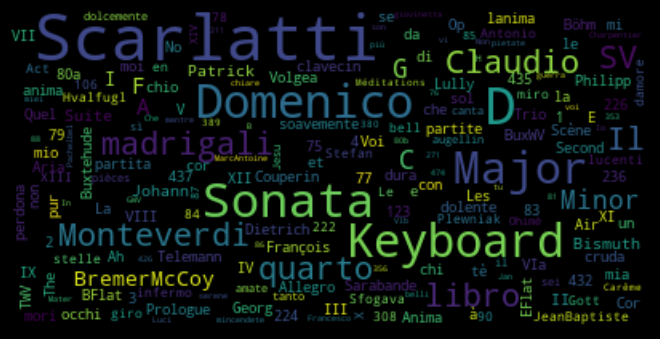

In [14]:
# Stopwords are the words that we want to exclude from the word cloud
# (there is a preconfigured dictionary of English stopwords in the wordcloud package,
# that we use as a starting point, and we add a few more words to exclude)

stopwords = set(wordcloud.STOPWORDS)
stopwords.add("Kk")
stopwords.add("de")
stopwords.add("in")
stopwords.add("pour")

# NOTE: Manually removing stopwords as wordcloud seems to ignore the stopwords argument

for word in stopwords:
    if word in tracks_freqdict:
        del tracks_freqdict[word]

# Create the word cloud
# See https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html for more options

wc = wordcloud.WordCloud(
    max_font_size=40,
    repeat=False,
    stopwords=stopwords
).generate_from_frequencies(tracks_freqdict)

# Display the figure

plt.figure(facecolor='k')                # black background
plt.imshow(wc, interpolation="bilinear") # plot word cloud
plt.axis("off")                          # no axes
plt.tight_layout(pad=0)                  # try to remove border
plt.show()                               # show image

## Calendar Heat Map of Listening History

In [64]:
# Get the most recent tracks played by the user

tracks_raw_data = network.get_user(LASTFM_USERNAME).get_recent_tracks(limit=None)


In [96]:
# This method takes a pylast.Track object and returns a string describing
# the timestamp

def convert_track_timestamp(
    track: pylast.Track,
) -> datetime.datetime:
    return datetime.datetime.fromtimestamp(int(track.timestamp)).date()

# Count the number of tracks played each day:

calendar = {}

for track in tracks_raw_data:

    timestamp = convert_track_timestamp(track)

    if timestamp not in calendar:
        calendar[timestamp] = 1
    else:
        calendar[timestamp] += 1

In [100]:
all_days = pd.date_range('1/1/2020', periods=365*3, freq='D')
events = pd.Series(calendar, index=all_days)
events.tail(10)

2022-12-21     NaN
2022-12-22     NaN
2022-12-23     2.0
2022-12-24     7.0
2022-12-25     NaN
2022-12-26     NaN
2022-12-27     NaN
2022-12-28     NaN
2022-12-29     5.0
2022-12-30    61.0
Freq: D, dtype: float64

/Users/jlumbroso/.local/share/virtualenvs/lastfm-analysis-template-uVcMYBuO/lib/python3.10/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/jlumbroso/.local/share/virtualenvs/lastfm-analysis-template-uVcMYBuO/lib/python3.10/site-packages/calmap/__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]


<AxesSubplot: >

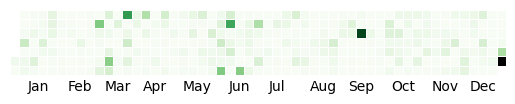

In [106]:
calmap.yearplot(
    events,
    year=2022,
    cmap="Greens",
    fillcolor="black",
    linewidth=0.5,
    linecolor="white",
    daylabels="",
)

/Users/jlumbroso/.local/share/virtualenvs/lastfm-analysis-template-uVcMYBuO/lib/python3.10/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/jlumbroso/.local/share/virtualenvs/lastfm-analysis-template-uVcMYBuO/lib/python3.10/site-packages/calmap/__init__.py:206: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  fill_data = by_day.pivot("day", "week", "fill").values[::-1]
/Users/jlumbroso/.local/share/virtualenvs/lastfm-analysis-template-uVcMYBuO/lib/python3.10/site-packages/calmap/__init__.py:202: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plot_data = by_day.pivot("day", "week", "data").values[::-1]
/Users/jlumbroso/.local/share/virtualenvs/lastfm-analysis-template-uVcMYBuO/lib/python3.10/site-packages/calmap/__init__.py:

(<Figure size 800x400 with 3 Axes>,
 array([<AxesSubplot: ylabel='2020'>, <AxesSubplot: ylabel='2021'>,
        <AxesSubplot: ylabel='2022'>], dtype=object))

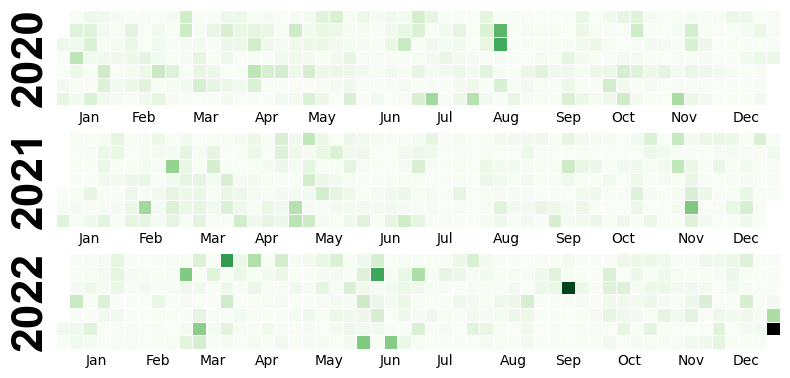

In [103]:
calmap.calendarplot(
    events,
    #year=2022,
    cmap="Greens",
    fillcolor="black",
    linewidth=0.5,
    linecolor="white",
    daylabels="",
    fig_kws=dict(figsize=(8, 4))
)
